<a href="https://colab.research.google.com/github/NikhilSandy/Image-Denoising-AutoEncoder-Using-CNN/blob/main/DENOISING_AE_ON_MNIST_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import numpy as np
import matplotlib.pyplot as plt
train_data=torchvision.datasets.MNIST(root='./data',train=True,transform=transform.ToTensor(),download=True)
test_data=torchvision.datasets.MNIST(root='./data',train=False,transform=transform.ToTensor(),download=False)
batch_size=64
train_loader=torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True)
epoch=int(input("Enter the value of no.of epochs:"))
learning_rate=0.001
buffer=1e-8

Enter the value of no.of epochs:10


In [37]:
class NN(nn.Module):
     def __init__(self):
         super(NN,self).__init__()
         self.conv1=nn.Conv2d(1,16,3,stride=2,padding=2)  #inputdims(m,1,28,28) conv1_out dims(m,16,16,16)
         self.relu=nn.ReLU()
         self.conv2=nn.Conv2d(16,32,3,stride=2,padding=1) #conv2_out dims(m,32,8,8) 
         self.conv3=nn.Conv2d(32,64,3,stride=2,padding=1) #conv3_out dims(m,64,4,4)
         self.l1=nn.Linear(1024,256)
         self.l2=nn.Linear(256,1024)
         self.conv4=nn.ConvTranspose2d(64,32,3,stride=3,padding=2) #conv4_out dims(m,32,8,8)
         self.conv5=nn.ConvTranspose2d(32,16,3,stride=3,padding=4)# conv5_out dims(m,16,16,16)
         self.conv6=nn.ConvTranspose2d(16,1,3,stride=2,padding=3,output_padding=1)#conv6_out dims(m,1,28,28)
         self.sigmoid=nn.Sigmoid()
     def forward(self,x):
         conv1_out=self.relu(self.conv1(x))
         conv2_out=self.conv2(conv1_out)
         conv3_out=self.conv3(conv2_out)
         flattened=torch.flatten(conv3_out,start_dim=1)
         l1_out=self.relu(self.l1(flattened))
         l2_out=self.relu(self.l2(l1_out))
         unflattened=l2_out.reshape(-1,64,4,4)
         conv4_out=self.relu(self.conv4(unflattened))
         conv5_out=self.relu(self.conv5(conv4_out))
         conv6_out=self.sigmoid(self.conv6(conv5_out))
         return conv6_out
model=NN()
loss=nn.MSELoss()
optimiser=torch.optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9,0.999),eps=1e-8,weight_decay=1e-5)
#weight decay to avoid overfitting
#eps to add numerical stability
print(model)

NN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (l1): Linear(in_features=1024, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=1024, bias=True)
  (conv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
  (conv5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(3, 3), padding=(4, 4))
  (conv6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
  (sigmoid): Sigmoid()
)


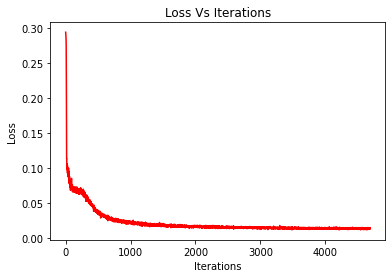

In [38]:
def add_noise(x):
    noise=torch.randn_like(x)*0.5
    return x+noise
def mask(x):
    y=torch.randn_like(x)<0.5
    x=x*y
    x=x/0.5
    return x 
iters=[]
cost_list=[]
i=0
for ep in range(epoch):
    for (features,_) in train_loader:
       noisy_input=add_noise(features)  #use whie adding gausian noise
       #noisy_input=mask(features)        #use whie adding mask to input
       #forward pass
       out_put=model.forward(noisy_input)
       #cost calculation
       cost=loss(out_put,features) #cost for single batch 
       cost_list.append(cost)
       iters.append(i)
       #back prop
       optimiser.zero_grad()
       cost.backward()
       #updating values
       optimiser.step()
       i+=1
plt.title("Loss Vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(iters,cost_list,'r')

ORIGINAL IMAGE


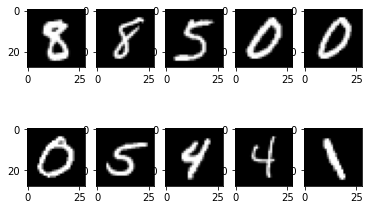

NOISY_INPUT IMAGE


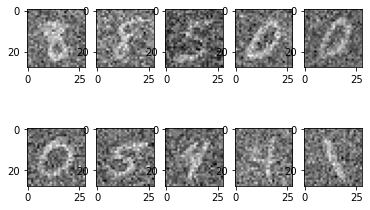

DENOISED IMAGE


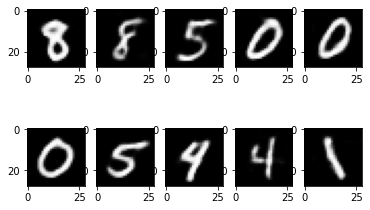

In [45]:
#TESTING 
with torch.no_grad():
       #forward pass
       features_test,labels_test=next(iter(test_loader))
       test_noise=add_noise(features_test) #use whie adding gausian noise
       #test_noise=mask(features_test)  #use whie adding mask to input
       predict=model.forward(test_noise)
       #plotting outputs
       print("ORIGINAL IMAGE")
       for k in range(10):
           plt.subplot(2,5,k+1)
           img=features_test[k,:]
           img=img.detach().numpy()
           img=img.reshape((28,28))
           plt.imshow(img,cmap='gray')
       plt.show()
       print("NOISY_INPUT IMAGE")
       for k in range(10):
           plt.subplot(2,5,k+1)
           img=test_noise[k,:]
           img=img.detach().numpy()
           img=img.reshape((28,28))
           plt.imshow(img,cmap='gray')
       plt.show()
       print("DENOISED IMAGE")
       for k in range(10):
           plt.subplot(2,5,k+1)
           img=predict[k,:]
           img=img.detach().numpy()
           img=img.reshape((28,28))
           plt.imshow(img,cmap='gray')
       plt.show()